# Loading data and preprocessing

In [1]:
import pandas as pd
import numpy as np
from ipywidgets import interact
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# Load the data
path = 'data/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/'
data = {f: pd.read_csv(path + f + '.csv') for f in ['campaign_desc', 'campaign_table',
                                                    'causal_data', 'coupon', 'coupon_redempt',
                                                    'hh_demographic', 'product',
                                                    'transaction_data']}

## Merge transactions set with other metadata

In [4]:
transactions = data["transaction_data"]\
                .merge(data["hh_demographic"], on="household_key", how="left")\
                .merge(data["product"], on="PRODUCT_ID", how="left")

## Compute some time based features

In [24]:
# compute an approximation of which month we are in (assuming all months are 30 days)
transactions["MONTH"] = (np.floor(transactions["DAY"] / 30) + 1).apply(int)

In [25]:
# Analyze weekday distribution
transactions.groupby("WEEK_NO")["DAY"].unique()

WEEK_NO
1                          [1, 2, 3, 4, 5]
2                 [6, 7, 8, 9, 10, 11, 12]
3             [13, 14, 15, 16, 17, 18, 19]
4             [20, 21, 22, 23, 24, 25, 26]
5             [27, 28, 29, 30, 31, 32, 33]
                      ...                 
98     [678, 679, 680, 681, 682, 683, 684]
99     [685, 686, 687, 688, 689, 690, 691]
100    [692, 693, 694, 695, 696, 697, 698]
101    [699, 700, 701, 702, 703, 704, 705]
102         [706, 707, 708, 709, 710, 711]
Name: DAY, Length: 102, dtype: object

We can see that first and last week are underrepresented, so we will drop them. The second week starts at 6 so we will devise this to be 1st day of the week.

Unfortunately we cannot exactly say which day is which weekday, 1st day can be Monday or Sunday based on two most common weekday numbering schemes.

In further analyses we have seen bigger sales on two last days of the week so we hypothesize this is the weekend (so that would mean first day is Monday) - this will be explained in a further section.

In [26]:
transactions["DAY_OF_WEEK"] = (transactions["DAY"] - 6) % 7 + 1

In [27]:
transactions["HOUR"] = np.floor(transactions.TRANS_TIME / 100).apply(int)

In [37]:
# We look at a random sample of the time features we generated to make sure they look ok
transactions[["HOUR", "DAY_OF_WEEK", "WEEK_NO", "DAY", "MONTH"]].sample(5)

,HOUR,DAY_OF_WEEK,WEEK_NO,DAY,MONTH
1003693,13,5,46,318,11
1037778,18,6,47,326,11
258953,18,3,19,127,5
1336060,21,4,58,401,14
1049072,15,1,48,328,11


## Create a demographic and product dataframe

In [32]:
missing_demographic = 100 * transactions.HOMEOWNER_DESC.isna().sum() / transactions.shape[0]
print(f"{missing_demographic}% of transactions doesn't have demographic data")

45.01346826251709% of transactions doesn't have demographic data


Since some transactions are missing demographic data, we create a dataframe that contains only transactions with demographic data for demographic analysis, and a second dataframe without these columns for other tasks.

In [33]:
transactions_demographic = transactions.dropna()

In [34]:
transactions_products = transactions.dropna(axis=1)

In [35]:
transactions_demographic.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,...,KID_CATEGORY_DESC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,MONTH,DAY_OF_WEEK,HOUR
11,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,...,None/Unknown,69,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ,1,3,15
12,1364,26984896261,1,897044,1,2.99,31742,-0.40,1520,1,...,None/Unknown,1075,GROCERY,National,CRACKERS/MISC BKD FD,SNACK CRACKERS,9.5 OZ,1,3,15
13,1364,26984896261,1,920955,1,3.09,31742,0.00,1520,1,...,None/Unknown,3664,MEAT,National,BEEF,GRND/PATTY - ROUND,,1,3,15
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,...,None/Unknown,2209,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,LINKS - RAW,12OZ,1,3,15
15,1364,26984896261,1,981760,1,0.60,31742,-0.79,1520,1,...,None/Unknown,69,GROCERY,Private,EGGS,EGGS - X-LARGE,1 DZ,1,3,15


In [36]:
transactions_products.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,...,COUPON_MATCH_DISC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,MONTH,DAY_OF_WEEK,HOUR
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,...,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,1,3,16
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,...,0.0,2,PRODUCE,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB,1,3,16
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,...,0.0,69,PRODUCE,Private,VEGETABLES - ALL OTHERS,CELERY,,1,3,16
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,...,0.0,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,1,3,16
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,...,0.0,69,PRODUCE,Private,ORGANICS FRUIT & VEGETABLES,ORGANIC CARROTS,1 LB,1,3,16


# Question 1: Shopping trends over time

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
def plot_trend(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(10,8))
    
    plt.plot(x, y, label="Actual values")
    
    reg = LinearRegression()
    x_reg = x.to_numpy().reshape(-1, 1)
    reg.fit(x_reg, y)
    plt.plot(x, reg.predict(x_reg), label="Linear trend")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [43]:
# we compute mean 
weekly = transactions.groupby(["household_key", "WEEK_NO"])["SALES_VALUE"].sum().groupby("WEEK_NO").mean().sort_index()

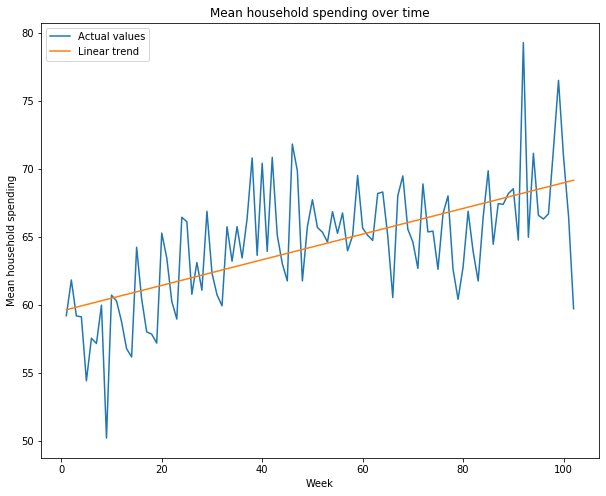

In [44]:
plot_trend(weekly.index, weekly, "Week", "Mean household spending", "Mean household spending over time")

There is a high deviation between subsequent weeks but we can see that the sales are overall increasing over time. The linear regression shows a rising tendency.

The big drop in the last week is most likely caused by the fact that this week is underrepresented (it doesn't contain the last day).

In [45]:
# Now we compute mean household spending in each month

In [46]:
monthly = transactions.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum().reset_index().groupby("MONTH")["SALES_VALUE"].mean()

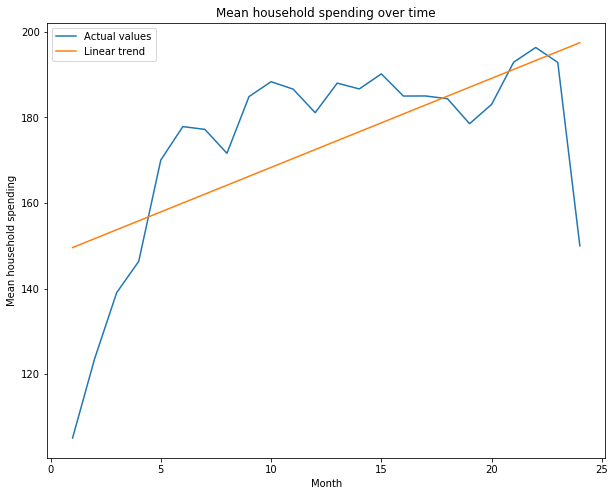

In [47]:
plot_trend(monthly.index, monthly, "Month", "Mean household spending", "Mean household spending over time")

In [51]:
transactions.groupby("MONTH")["DAY"].unique().apply(len)

MONTH
1     29
2     30
3     30
4     30
5     30
6     30
7     30
8     30
9     30
10    30
11    30
12    30
13    30
14    30
15    30
16    30
17    30
18    30
19    30
20    30
21    30
22    30
23    30
24    22
Name: DAY, dtype: int64

As we can see, due to our approximation last month contains less days than the other, so it is underrepresented. That explains the big drop at the end.

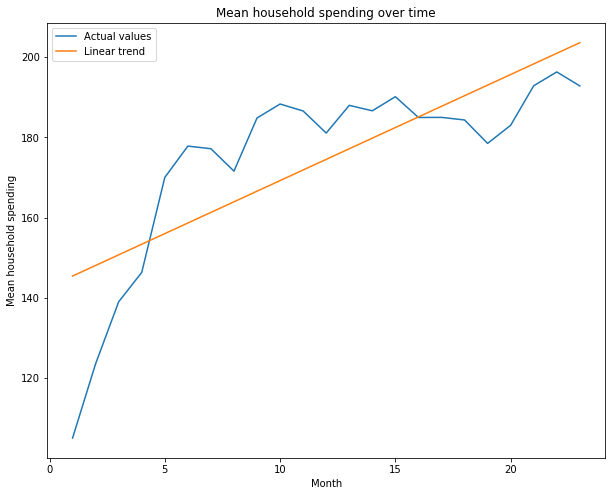

In [53]:
monthly = monthly[monthly.index < 24]
plot_trend(monthly.index, monthly, "Month", "Mean household spending", "Mean household spending over time")

So we remove the last underrepresented month. The sales are clearly increasing over time and the linear trend is highly increasing.

We hypothesize there could be 2 factors accounting for the increase:
- people are generally spending more money on shopping over time
- due to advertising campaigns, people more often choose the store we have data for and they do a bigger part of their shopping there than before (so it's possible they spend the same amount overall, just the place where they spend the money has changed)
    
Most likely both of these factors are at play here. We could analyse the efficiency of advertising to understand that better.